# Kaggle Digit Recognizer
## Single and Multi Layer simple Neural Network Model


In this notebook, We are going to implement single and multilayer Neural network architecture.



### Step1
Follwing cell is to Import all relevant library also declare macros which we are going to use in this notebook

In [1]:
import tensorflow as tf
from random import randint
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pre_processing 

# Network Parameters
# All the pixels in the image (28 * 28 = 784)
features_count = 784 # MNIST data input (img shape: 28*28)
# All the labels
labels_count = 10 # MNIST total classes (0-9 digits)
# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons

# multilayer_perceptron
learning_rate_ml = 0.0001

# singlelayer_perceptron
learning_rate = 0.05

# Change if you have memory restrictions
batch_size = 100

# TODO: Find the best parameters for each configuration
epochs = 10

save_model_path = './digit_recognition'
data = np.zeros(shape=(10000,28*28))

print ('Successfully Import of library ')

Successfully Import of library 


### step 2
get the data for network model
Data's are, train feature & label, cross-validation fetures & labels, and test feature and labels.
All labels are encoded.
All features are rescaled between -0.5 to 0.5 from 0 - 255


In [2]:
def get_data():
    return pre_processing.get_processed_data()

### Step 3
Now it's time to build a simple neural network using TensorFlow. Here, your network will be just an input layer and an output layer.
For the input here the images have been flattened into a vector of 28×28=784 features. Then, we're trying to predict the image digit so there are 10 output units, one for each label. For the neural network to train on your data, we need the following float32 tensors:
features: Placeholder tensor for feature data (train_features/valid_features/test_features)
labels: Placeholder tensor for label data (train_labels/valid_labels/test_labels)
weights: Variable Tensor with random numbers from a truncated normal distribution.
biases: Variable Tensor with all zeros.

In [3]:

def singlelayer_perceptron(x):
    # TODO: Set the weights and biases tensors
    weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
    biases = tf.Variable(tf.zeros(labels_count))
    
    out_layer = tf.matmul(x, weights) + biases
    return out_layer
    
def multilayer_perceptron(x):
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([features_count, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, labels_count]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([labels_count]))
    }
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer


### Step 3: NN creation
#### Step 3a:
Create a single layer nn model

In [4]:
def single_layer_nn(features, labels):
    # Linear Function WX + b
    #logits = tf.matmul(features, weights) + biases
    logits = singlelayer_perceptron(features)

    # Name logits Tensor, so that is can be loaded from disk after training
    #display (logits.shape)
    logits = tf.identity(logits, name='logits')

    prediction = tf.nn.softmax(logits)

    # Cross entropy
    cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

    # Define loss and optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))
    print('single layer nn infra is done')

    return logits, prediction, cross_entropy, loss

#### Step 3b
Create a multi layer nn model

In [5]:
def multi_layer_nn(features, labels):
    # multilayer perception model
    logits = multilayer_perceptron(features)
    # Name logits Tensor, so that is can be loaded from disk after training
    #display (logits.shape)
    logits = tf.identity(logits, name='logits')

    prediction = tf.nn.softmax(logits)

    # Cross entropy
    cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

    # Define loss and optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))
    print('multi layer nn infra is done')

    return logits, prediction, cross_entropy, loss


### Step 4
Create model for nn using tensorflow

In [6]:
def model():
    # Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()

    # Set the features and labels tensors
    features = tf.placeholder(tf.float32, name="features")
    labels = tf.placeholder(tf.float32, name="label")
    
    logits, prediction, cross_entropy, loss = single_layer_nn(features, labels)
    logits_ml, prediction_ml, cross_entropy_ml, loss_ml = multi_layer_nn(features, labels)
    # Determine if the predictions are correct
    is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    is_correct_prediction_ml = tf.equal(tf.argmax(prediction_ml, 1), tf.argmax(labels, 1))
    # Calculate the accuracy of the predictions
    accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32),name='accuracy')
    accuracy_ml = tf.reduce_mean(tf.cast(is_correct_prediction_ml, tf.float32),name='accuracy_ml')

    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate, name='GDoptimizer').minimize(loss) 
    
    optimizer_ml = tf.train.GradientDescentOptimizer(learning_rate_ml).minimize(loss,name='GDoptimizer_ml') 

    print('Accuracy function created.')
    return features, labels, logits, prediction, cross_entropy, loss, accuracy, optimizer
    return features, labels, logits_ml, prediction_ml, cross_entropy_ml, loss_ml, accuracy_ml, optimizer_ml

### Step 5:
Train the model

In [16]:
def train_model(train_features, train_labels, valid_features, valid_labels, test_data, test_label):
    # The accuracy measured against the validation set
    validation_accuracy = 0.0

    # Measurements use for graphing loss and accuracy
    log_batch_step = 50
    batches = []
    loss_batch = []
    train_acc_batch = []
    valid_acc_batch = []
    
    features, labels, logits, prediction, cross_entropy, loss, accuracy, optimizer = model()
    
    # Feed dicts for training, validation, and test session
    train_feed_dict = {features: train_features, labels: train_labels}
    valid_feed_dict = {features: valid_features, labels: valid_labels}
    

    # Create an operation that initializes all variables
    init = tf.global_variables_initializer()

    with tf.Session() as session:
        session.run(init)
        batch_count = int(math.ceil(len(train_features)/batch_size))

        for epoch_i in range(epochs):
            avg_cost = 0  
            # Progress bar
            batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
           # display((batch_count))
            # The training cycle
            for batch_i in batches_pbar:
                # Get a batch of training features and labels
                batch_start = batch_i*batch_size
                batch_features = train_features[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]

                # Run optimizer and get loss
                _, l = session.run(
                    [optimizer, loss],
                    feed_dict={features: batch_features, labels: batch_labels})
            
                avg_cost += l / batch_size
                        
                # Log every 50 batches
                if not batch_i % log_batch_step:
                    # Calculate Training and Validation accuracy
                    training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)
                    #display(training_accuracy,)

            print ("Epoch:", (epoch_i+1), "cost =", "{:.5f}".format(avg_cost))
            # Check accuracy against Validation data
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
            print('Validation accuracy at {}'.format(validation_accuracy))

        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(session, save_model_path)

    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()



### Step 6:
Test the model against hold out dataset/testing data. This will give you a good indicator of how well the model will do in the real world. 

In [17]:
def test_model(train_features, train_labels, valid_features, valid_labels, test_data, test_label):
    # The accuracy measured against the test set
    test_accuracy = 0.0
    loaded_graph = tf.Graph()
    n_samples = 4
    top_n_predictions = 3
    
    #features, labels, logits, prediction, cross_entropy, loss, accuracy, optimizer = model()
    
    #test_feed_dict = {features: test_data, labels: test_label}
    #train_feed_dict = {features: train_features, labels: train_labels}
    #valid_feed_dict = {features: valid_features, labels: valid_labels}

    # Create an operation that initializes all variables
    #init = tf.global_variables_initializer()
    
    #with tf.Session() as session:
    with tf.Session(graph=loaded_graph) as session:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(session, save_model_path)
        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('features:0')
        loaded_y = loaded_graph.get_tensor_by_name('label:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        #loaded_GDoptimizer = loaded_graph.get_tensor_by_name('GDoptimizer:0')      
        #session.run(init)
        #batch_count = int(math.ceil(len(train_features)/batch_size))
        #for epoch_i in range(epochs):
            # Progress bar
            #batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
            # The training cycle
            #for batch_i in batches_pbar:
                # Get a batch of training features and labels
            #    batch_start = batch_i*batch_size
            #    batch_features = train_features[batch_start:batch_start + batch_size]
            #    batch_labels = train_labels[batch_start:batch_start + batch_size]

                # Run optimizer
             #   _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

            # Check accuracy against Test data
        test_accuracy = session.run(loaded_acc, feed_dict={loaded_x: test_data, loaded_y: test_label})
            #training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
        # Print Random Samples
    #    random_test_features = test_data[10]
    #    random_test_labels = test_label_encoded[10]
    #    random_test_predictions = session.run(
    #            tf.nn.top_k(tf.nn.softmax(logits), top_n_predictions),
    #            feed_dict={features: random_test_features, labels: random_test_labels})

    #printf('prdiction {} '.format(random_test_predictions))
    #printf('actual {}'.format(test_label_encoded))
        #print('Training Accuracy is {}'.format(training_accuracy))
        assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
        print('Nice Job! Test Accuracy is {}'.format(test_accuracy))


### Step 7:
Test the random image to verify how good the modle is

In [18]:
def test_random_image(data):
    # test ramdom image
    loaded_graph = tf.Graph()
    top_n_predictions = 3

    with tf.Session(graph=loaded_graph) as session:
    # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(session, save_model_path)
        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('features:0')
        loaded_y = loaded_graph.get_tensor_by_name('label:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    #    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    #    loaded_GDoptimizer = loaded_graph.get_tensor_by_name('GDoptimizer:0')      

        num = randint(0, data.shape[0])
        print ('num:', num)
        img = data[num]
        classification = session.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions), feed_dict={loaded_x: [img]})
        plt.imshow(img.reshape(28, 28), cmap=plt.cm.binary)
        plt.show()
        print ('Top {} prediction :' .format(top_n_predictions))
        print ('{}% ' .format(classification[0]*100) )
        print ('predicted value {}' .format(classification[1]))
 

### Step 8
main function

data processing
get_data
downloading train-images-idx3-ubyte.gz
downloading train-labels-idx1-ubyte.gz
downloading t10k-images-idx3-ubyte.gz
downloading t10k-labels-idx1-ubyte.gz
Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz
All features and labels uncompressed.
Training features and labels randomized and split.
single layer nn infra is done
multi layer nn infra is done
Accuracy function created.


Epoch  1/10: 100%|█████████████████████| 570/570 [00:02<00:00, 228.51batches/s]


Epoch: 1 cost = 17.13366
Validation accuracy at 0.6943333148956299


Epoch  2/10: 100%|█████████████████████| 570/570 [00:02<00:00, 230.03batches/s]


Epoch: 2 cost = 7.01722
Validation accuracy at 0.7689999938011169


Epoch  3/10: 100%|█████████████████████| 570/570 [00:02<00:00, 225.01batches/s]


Epoch: 3 cost = 5.50473
Validation accuracy at 0.8033333420753479


Epoch  4/10: 100%|█████████████████████| 570/570 [00:02<00:00, 211.92batches/s]


Epoch: 4 cost = 4.79539
Validation accuracy at 0.8209999799728394


Epoch  5/10: 100%|█████████████████████| 570/570 [00:02<00:00, 232.95batches/s]


Epoch: 5 cost = 4.35713
Validation accuracy at 0.8339999914169312


Epoch  6/10: 100%|█████████████████████| 570/570 [00:02<00:00, 235.42batches/s]


Epoch: 6 cost = 4.05067
Validation accuracy at 0.8463333249092102


Epoch  7/10: 100%|█████████████████████| 570/570 [00:02<00:00, 233.69batches/s]


Epoch: 7 cost = 3.82054
Validation accuracy at 0.8536666631698608


Epoch  8/10: 100%|█████████████████████| 570/570 [00:02<00:00, 234.15batches/s]


Epoch: 8 cost = 3.63915
Validation accuracy at 0.8586666584014893


Epoch  9/10: 100%|█████████████████████| 570/570 [00:02<00:00, 233.95batches/s]


Epoch: 9 cost = 3.49104
Validation accuracy at 0.862666666507721


Epoch 10/10: 100%|█████████████████████| 570/570 [00:02<00:00, 232.45batches/s]


Epoch: 10 cost = 3.36685
Validation accuracy at 0.8679999709129333


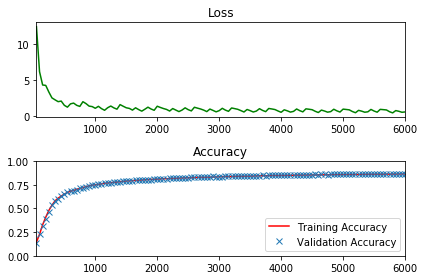

INFO:tensorflow:Restoring parameters from ./digit_recognition
Nice Job! Test Accuracy is 0.8698999881744385


In [19]:
def nn_main():
    train_features, valid_features, train_labels, valid_labels, test_data, test_label = get_data()
    train_model(train_features, train_labels, valid_features, valid_labels, test_data, test_label)
    test_model(train_features, train_labels, valid_features, valid_labels, test_data, test_label)
    #data = test_data
    return test_data
 
data = nn_main() 


### Step 9
Test the random image

INFO:tensorflow:Restoring parameters from ./digit_recognition
num: 387


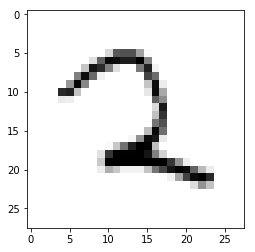

Top 3 prediction :
[[  9.99780273e+01   1.56723745e-02   4.65721963e-03]]% 
predicted value [[2 7 9]]


In [15]:
test_random_image(data)